<a href="https://colab.research.google.com/github/ratmcu/bois/blob/master/bois.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
import os
import shutil
if os.path.exists('Selfie_Filters_OpenCV') :
    shutil.rmtree('Selfie_Filters_OpenCV')
!git clone https://github.com/ratmcu/Selfie_Filters_OpenCV.git
# !conda env create -f path/to/environment.yml
!export PYTHONPATH=$PYTHONPATH:'Selfie_Filters_OpenCV'
sys.path.append('Selfie_Filters_OpenCV')
# !python test_image.py
from my_CNN_model import *
import cv2
import numpy as np
import math

Cloning into 'Selfie_Filters_OpenCV'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 67 (delta 3), reused 8 (delta 3), pack-reused 56
Unpacking objects: 100% (67/67), done.


Using TensorFlow backend.


In [6]:
from my_CNN_model import *
import cv2
import numpy as np

# Load the model built in the previous step
my_model = load_my_CNN_model('Selfie_Filters_OpenCV/my_model')

# Face cascade to detect faces
face_cascade = cv2.CascadeClassifier('Selfie_Filters_OpenCV/'+'cascades/haarcascade_frontalface_default.xml')

# Define the upper and lower boundaries for a color to be considered "Blue"
blueLower = np.array([100, 60, 60])
blueUpper = np.array([140, 255, 255])

# Define a 5x5 kernel for erosion and dilation
kernel = np.ones((5, 5), np.uint8)

# Define filters
filters = ['images/sunglasses.png', 'images/sunglasses_2.png', 'images/sunglasses_3.jpg', 'images/sunglasses_4.png', 'images/sunglasses_5.jpg', 'images/sunglasses_6.png']
filters = ['Selfie_Filters_OpenCV/'+filter for filter in filters]
filterIndex = 0

# Load the video
# camera = cv2.VideoCapture(0)
import matplotlib.pyplot as plt
import random
import pylab

figure = pylab.figure()
figure.suptitle('Selfie Filters', fontsize=20)
# Keep looping
while True:
    # Grab the current paintWindow
#     (grabbed, frame) = camera.read()
    frame = cv2.imread("Selfie_Filters_OpenCV/images/bois.jpeg")
#     frame = cv2.imread("fn3.jpg")
    img_bg = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.flip(frame, 1)
    img_bg = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame2 = np.copy(frame)
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Add the 'Next Filter' button to the frame
    frame = cv2.rectangle(frame, (500,10), (620,65), (235,50,50), -1)
    cv2.putText(frame, "NEXT FILTER", (512, 37), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA)

    # Detect faces
    faces = face_cascade.detectMultiScale(gray, 1.25, 6)

#     Determine which pixels fall within the blue boundaries and then blur the binary image
#     blueMask = cv2.inRange(hsv, blueLower, blueUpper)
#     blueMask = cv2.erode(blueMask, kernel, iterations=2)
#     blueMask = cv2.morphologyEx(blueMask, cv2.MORPH_OPEN, kernel)
#     blueMask = cv2.dilate(blueMask, kernel, iterations=1)

    # Find contours (bottle cap in my case) in the image
#     (_, cnts, _) = cv2.findContours(blueMask.copy(), cv2.RETR_EXTERNAL,
#     	cv2.CHAIN_APPROX_SIMPLE)
#     center = None

#     Check to see if any contours were found
#     if len(cnts) > 0:
#     	# Sort the contours and find the largest one -- we
#     	# will assume this contour correspondes to the area of the bottle cap
#         cnt = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
#         # Get the radius of the enclosing circle around the found contour
#         ((x, y), radius) = cv2.minEnclosingCircle(cnt)
#         # Draw the circle around the contour
#         cv2.circle(frame, (int(x), int(y)), int(radius), (0, 255, 255), 2)
#         # Get the moments to calculate the center of the contour (in this case Circle)
#         M = cv2.moments(cnt)
#         center = (int(M['m10'] / M['m00']), int(M['m01'] / M['m00']))

#         if center[1] <= 65:
#             if 500 <= center[0] <= 620: # Next Filter
#                 filterIndex += 1
#                 filterIndex %= 6
#                 continue
    face_id = 1
    for (x, y, w, h) in faces:

        # Grab the face
        gray_face = gray[y:y+h, x:x+w]
        color_face = frame[y:y+h, x:x+w]

        # Normalize to match the input format of the model - Range of pixel to [0, 1]
        gray_normalized = gray_face / 255

        # Resize it to 96x96 to match the input format of the model
        original_shape = gray_face.shape # A Copy for future reference
        face_resized = cv2.resize(gray_normalized, (96, 96), interpolation = cv2.INTER_AREA)
        face_resized_copy = face_resized.copy()
        face_resized = face_resized.reshape(1, 96, 96, 1)

        # Predicting the keypoints using the model
        keypoints = my_model.predict(face_resized)

        # De-Normalize the keypoints values
        keypoints = keypoints * 48 + 48

        # Map the Keypoints back to the original image
        face_resized_color = cv2.resize(color_face, (96, 96), interpolation = cv2.INTER_AREA)
        face_resized_color2 = np.copy(face_resized_color)

        # Pair them together
        points = []
        for i, co in enumerate(keypoints[0][0::2]):
            points.append((co, keypoints[0][1::2][i]))

        # read the filter
        sunglasses = cv2.imread(filters[filterIndex], cv2.IMREAD_UNCHANGED)
        pivot_points = [(40, 30), (140, 30)]
        face_resized_color = paste_mask([points[1], points[0]], pivot_points, sunglasses, face_resized_color)
        face_resized_color = cv2.cvtColor(face_resized_color, cv2.COLOR_BGR2RGB)
        # fill the area relavant to the frame on the bigger image
        img_bg[y:y+h, x:x+w] = cv2.resize(face_resized_color, original_shape, interpolation = cv2.INTER_CUBIC)

#         cv2.circle(face_resized_color, points[0], 1, (0,255,0), 1) #right eye
#         cv2.circle(face_resized_color, points[1], 1, (0,255,0), 1) #left eye

    break
pylab.imshow(img_bg)
pylab.show()

W0620 01:27:50.808172 140379876706176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0620 01:27:50.850701 140379876706176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0620 01:27:50.857570 140379876706176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0620 01:27:50.883289 140379876706176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0620 01:27:50.901451 140379876706176 deprecation_wrapp

0.35125606436602097


IndexError: ignored

<Figure size 432x288 with 0 Axes>

0.282842712474619


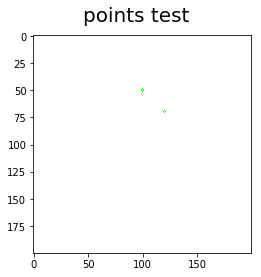

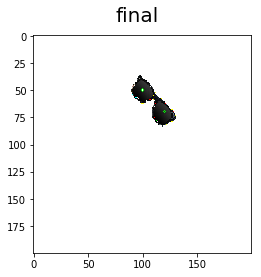

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pylab


filters = ['images/sunglasses.png', 'images/sunglasses_2.png', 'images/sunglasses_3.jpg', 'images/sunglasses_4.png', 'images/sunglasses_5.jpg', 'images/sunglasses_6.png']
filters = ['Selfie_Filters_OpenCV/'+filter for filter in filters]
filterIndex = 0

figure = pylab.figure()
figure.suptitle('points test', fontsize=20)
# detected_eyes = [(100, 50), (120, 70)]
detected_eyes = [(100, 50), (120, 70)]
original_eyes = [(40, 30), (140, 30)]
# original_eyes = [(40, 30), (140, 30)]

size = 200, 200, 3
m = np.ones(size, dtype=np.uint8)*255
# m = cv2.cvtColor(m, cv2.COLOR_RGB2RGBA)
# print(m.shape)
# cv2.circle(m, (20,50), 1, (0,255,0), 1)
sunglasses = cv2.imread(filters[filterIndex], cv2.IMREAD_UNCHANGED)
# figure = pylab.figure()
# figure.suptitle('++++', fontsize=20)
cv2.circle(m, detected_eyes[0], 1, (0,255,0), 1)
cv2.circle(m,  detected_eyes[1], 1, (0,255,0), 1)
pylab.imshow(m[:,:,:3])
# figure = pylab.figure()
# figure.suptitle('----', fontsize=20)
cv2.circle(sunglasses,  original_eyes[0], 1, (0,255,0), -1)
# cv2.circle(sunglasses, (20, 20), 5, (255,0,0), -1)

# pylab.imshow(sunglasses)

# angle = -(math.atan((points[1][1]-points[0][1])/(points[1][0]-points[0][0]))*(180))/math.pi
scale = math.sqrt((detected_eyes[1][1]-detected_eyes[0][1])*(detected_eyes[1][1]-detected_eyes[0][1]) + 
                  (detected_eyes[1][0]-detected_eyes[0][0])*(detected_eyes[1][0]-detected_eyes[0][0]))/math.sqrt((original_eyes[1][1]-original_eyes[0][1])*(original_eyes[1][1]-original_eyes[0][1]) +
                  ((original_eyes[1][0]-original_eyes[0][0])*(original_eyes[1][0]-original_eyes[0][0])))
angle = (math.atan2((detected_eyes[0][1]-detected_eyes[1][1]), -(detected_eyes[0][0]-detected_eyes[1][0]))*(180))/math.pi
rows, cols, channels = sunglasses.shape
# print(rows, cols, channels)
dr = rows - original_eyes[0][1]
dc = cols - original_eyes[0][0]
hyp = int(math.sqrt(dr*dr + dc*dc))
# print(rows, cols, hyp)
top    = int(hyp-original_eyes[0][0])  #
bottom = int(hyp-rows+original_eyes[0][1])
left   = int(hyp-original_eyes[0][1])  # shape[1] = cols
right  = int(hyp-(cols-original_eyes[0][0]))
print(scale)
value = [0, 0, 0]
borderType = cv2.BORDER_CONSTANT
sunglass_resized = cv2.copyMakeBorder(sunglasses, top, bottom, left, right, borderType, None, value)
# figure = pylab.figure()
# figure.suptitle('bordered', fontsize=20)
# pylab.imshow(sunglass_resized)
bordered_dim = sunglass_resized.shape
M = cv2.getRotationMatrix2D((original_eyes[0][0]+left,original_eyes[0][1]+top), angle, 1)
sunglass_resized = cv2.warpAffine(sunglass_resized, M, (int(bordered_dim[1]), int(bordered_dim[0])))
sunglass_width = int((bordered_dim[0])*scale)
sunglass_height = int((bordered_dim[1])*scale)
sunglass_resized = cv2.resize(sunglass_resized, (sunglass_width, sunglass_height), interpolation = cv2.INTER_CUBIC)
# print(sunglass_resized.shape)
# figure = pylab.figure()
# figure.suptitle('resized', fontsize=20)
# cv2.circle(sunglass_resized, (int(original_eyes[0][0]), int(original_eyes[0][1])), 1, (0,0,255), 1)
# cv2.circle(sunglass_resized, (20, 20), 1, (0,0,255), 1)
new_eyes = original_eyes.copy()
# print(new_eyes[0][0])
new_eyes[0] = list(new_eyes[0])
new_eyes[1] = list(new_eyes[1])
new_eyes[0][0] = original_eyes[0][0]+top
new_eyes[0][1] = original_eyes[0][1]+left
cv2.circle(sunglass_resized,  (int(new_eyes[0][0]*scale), int(new_eyes[0][1]*scale)), 1, (255,0,0), -1)
# pylab.imshow(sunglass_resized)
transparent_region = sunglass_resized[:,:,:3] != 0
#adding the sunglasses to the face
start_point_row = int(detected_eyes[0][1]-int(new_eyes[0][1]*scale))
start_point_col = int(detected_eyes[0][0]-int(new_eyes[0][0]*scale))
m[start_point_row:start_point_row+sunglass_height, 
                   start_point_col:start_point_col+sunglass_width,:][transparent_region] = sunglass_resized[:,:,:3][transparent_region]
cv2.circle(m, detected_eyes[0], 1, (0,255,0), 1)
cv2.circle(m,  detected_eyes[1], 1, (0,255,0), 1)
figure = pylab.figure()
figure.suptitle('final', fontsize=20)
pylab.imshow(m)

In [0]:
def paste_mask(detected, pivots, mask, face):
    cv2.circle(face, detected[0], 1, (0,255,0), 1)
    cv2.circle(face,  detected[1], 1, (0,255,0), 1)
    scale = math.sqrt((detected[1][1]-detected[0][1])*(detected[1][1]-detected[0][1]) + 
                    (detected[1][0]-detected[0][0])*(detected[1][0]-detected[0][0]))/math.sqrt((pivots[1][1]-pivots[0][1])*(pivots[1][1]-pivots[0][1]) +
                              ((pivots[1][0]-pivots[0][0])*(pivots[1][0]-pivots[0][0])))
    angle = (math.atan2((detected[0][1]-detected[1][1]), -(detected[0][0]-detected[1][0]))*(180))/math.pi
    rows, cols, channels = mask.shape
    print(rows, cols, channels)
    dr = rows - pivots[0][1]
    dc = cols - pivots[0][0]
    hyp = int(math.sqrt(dr*dr + dc*dc))
    # print(rows, cols, hyp)
    # add the borders so the rotation won't clip any of the mask 
    top    = int(hyp-pivots[0][0])  #
    bottom = int(hyp-rows+pivots[0][1])
    left   = int(hyp-pivots[0][1])  # shape[1] = cols
    right  = int(hyp-(cols-pivots[0][0]))
    print(scale)
    value = [0, 0, 0]
    borderType = cv2.BORDER_CONSTANT
    mask_resized = cv2.copyMakeBorder(mask, top, bottom, left, right, borderType, None, value)
    # figure = pylab.figure()
    # figure.suptitle('bordered', fontsize=20)
    # pylab.imshow(mask_resized)

    # rotate the mask inside the safely resized canvas
    bordered_dim = mask_resized.shape
    M = cv2.getRotationMatrix2D((pivots[0][0]+left, pivots[0][1]+top), angle, 1)
    mask_resized = cv2.warpAffine(mask_resized, M, (int(bordered_dim[1]), int(bordered_dim[0])))

    # resize the mask to match the scaling of the seperation between the face
    sunglass_width = int((bordered_dim[0])*scale)
    sunglass_height = int((bordered_dim[1])*scale)
    mask_resized = cv2.resize(mask_resized, (sunglass_width, sunglass_height), interpolation = cv2.INTER_CUBIC)
    # print(mask_resized.shape)
    # figure = pylab.figure()
    # figure.suptitle('resized', fontsize=20)
    # cv2.circle(mask_resized, (int(original_eyes[0][0]), int(original_eyes[0][1])), 1, (0,0,255), 1)
    # cv2.circle(mask_resized, (20, 20), 1, (0,0,255), 1)
    new_eyes = pivots.copy()
    # print(new_eyes[0][0])
    new_eyes[0] = list(new_eyes[0])
    new_eyes[1] = list(new_eyes[1])
    new_eyes[0][0] = pivots[0][0]+top
    new_eyes[0][1] = pivots[0][1]+left
    cv2.circle(mask_resized,  (int(new_eyes[0][0]*scale), int(new_eyes[0][1]*scale)), 1, (255,0,0), -1)
    # pylab.imshow(mask_resized)
    transparent_region = mask_resized[:,:,:3] != 0
    #adding the sunglasses to the face
    # find the pixel position of the mask canvas to start on the face and fill the face
    start_point_row = int(detected[0][1]-int(new_eyes[0][1]*scale))
    start_point_col = int(detected[0][0]-int(new_eyes[0][0]*scale))
    face[start_point_row:start_point_row+sunglass_height, 
                    start_point_col:start_point_col+sunglass_width,:][transparent_region] = mask_resized[:,:,:3][transparent_region]
    cv2.circle(face, detected[0], 1, (0,255,0), 1)
    cv2.circle(face,  detected[1], 1, (0,255,0), 1)
    return face

0.282842712474619


<Figure size 432x288 with 0 Axes>

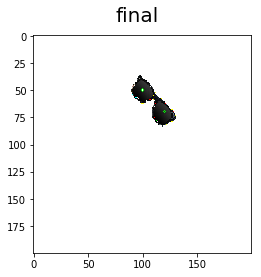

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pylab

filters = ['images/sunglasses.png', 'images/sunglasses_2.png', 'images/sunglasses_3.jpg', 'images/sunglasses_4.png', 'images/sunglasses_5.jpg', 'images/sunglasses_6.png']
filters = ['Selfie_Filters_OpenCV/'+filter for filter in filters]
filterIndex = 0

figure = pylab.figure()
figure.suptitle('points test', fontsize=20)
# detected_eyes = [(100, 50), (120, 70)]
detected_eyes = [(100, 50), (120, 70)]
original_eyes = [(40, 30), (140, 30)]
# original_eyes = [(40, 30), (140, 30)]

size = 200, 200, 3
m = np.ones(size, dtype=np.uint8)*255
# m = cv2.cvtColor(m, cv2.COLOR_RGB2RGBA)
# print(m.shape)
# cv2.circle(m, (20,50), 1, (0,255,0), 1)
sunglasses = cv2.imread(filters[filterIndex], cv2.IMREAD_UNCHANGED)
m = paste_mask(detected_eyes, original_eyes, sunglasses, m)
figure = pylab.figure()
figure.suptitle('final', fontsize=20)
pylab.imshow(m)